# Ingredients based Food Recommendation System
##### Ingredient based food recommendations sytem has been built targeting online food ordering platforms. Ideally the recommendation system should provide N number of recommended food based on user's last ordered food. Here, the last ordered food are considered as the queried food. The recommeded foods are predicted based on the similarity of ingredients between queried food and other available food items within food item profile. To predict the recommendations a TF-IDF matrix for all food ingredients has been built within Vector Space Model(SVD). From the TF-IDF weights similarity score has been calculated between queried and other food items based on ingredients. Here, three similarity algorithm has been implemented to compare their results, these are - Cosine similarity, Euclidean Distance and Pearson Correlation.

### Steps followed: 
#### 1. Load and Merge data.
#### 2. EDA.
#### 3. TF-IDF Modeling
#### 4. Similarity Algorithm
#### 5. Recommendation functions.

In [21]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from sklearn.feature_extraction.text import  CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel 
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats.stats import pearsonr
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

## Step-1: Load Data & Merge Data

In [22]:
recipe_df=pd.read_csv("RAW_recipes.csv").fillna(0)
user_order=pd.read_csv("RAW_interactions.csv").fillna(0)
#sample_df=pd.read_excel("sample_df.xlsx").fillna(0)
pd.set_option("display.max_colwidth", -1)

C:\Users\iPric\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


##### Note: For research purpose considering 10000 rows to build the recommender system

In [24]:
sample_df=recipe_df[['name','id','ingredients']].head(10000)
sample_df.head(5)

,name,id,ingredients
0,arriba baked winter squash mexican style,137739,"['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']"
1,a bit different breakfast pizza,31490,"['prepared pizza crust', 'sausage patty', 'eggs', 'milk', 'salt and pepper', 'cheese']"
2,all in the kitchen chili,112140,"['ground beef', 'yellow onions', 'diced tomatoes', 'tomato paste', 'tomato soup', 'rotel tomatoes', 'kidney beans', 'water', 'chili powder', 'ground cumin', 'salt', 'lettuce', 'cheddar cheese']"
3,alouette potatoes,59389,"['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']"
4,amish tomato ketchup for canning,44061,"['tomato juice', 'apple cider vinegar', 'sugar', 'salt', 'pepper', 'clove oil', 'cinnamon oil', 'dry mustard']"


In [27]:
df_merge_user_recipe = pd.merge(user_order, sample_df, left_on='recipe_id', right_on='id')

df_merge_user_recipe[['user_id','recipe_id','name','rating','ingredients']]

,user_id,recipe_id,name,rating,ingredients
0,135017,254596,apple apricot pork chops crock pot,5,"['pork chops', 'apple', 'dried apricot', 'cranberries', 'onion', 'celery', 'apple juice', 'brown sugar', 'wine', 'salt and pepper', 'cornstarch', 'cold water']"
1,224088,254596,apple apricot pork chops crock pot,4,"['pork chops', 'apple', 'dried apricot', 'cranberries', 'onion', 'celery', 'apple juice', 'brown sugar', 'wine', 'salt and pepper', 'cornstarch', 'cold water']"
2,582223,254596,apple apricot pork chops crock pot,5,"['pork chops', 'apple', 'dried apricot', 'cranberries', 'onion', 'celery', 'apple juice', 'brown sugar', 'wine', 'salt and pepper', 'cornstarch', 'cold water']"
3,1413963,254596,apple apricot pork chops crock pot,5,"['pork chops', 'apple', 'dried apricot', 'cranberries', 'onion', 'celery', 'apple juice', 'brown sugar', 'wine', 'salt and pepper', 'cornstarch', 'cold water']"
4,6258,20930,2 tomato pasta salad,5,"['pasta', 'bacon', 'red peppers', 'sun-dried tomatoes', 'olive oil', 'mozzarella cheese', 'pine nuts', 'fresh oregano', 'chives', 'cherry tomatoes', 'white vinegar', 'sugar', 'balsamic vinegar', 'garlic', 'french mustard']"
...,...,...,...,...,...
48735,457661,213546,arin s potatoes,5,"['canned whole potatoes', 'lemon pepper', 'salt', 'season salt', 'oregano', 'butter']"
48736,169430,190261,anise carrots,5,"['carrot', 'onion', 'butter', 'anise', 'apricot preserves', 'salt', 'pepper']"
48737,58104,190261,anise carrots,5,"['carrot', 'onion', 'butter', 'anise', 'apricot preserves', 'salt', 'pepper']"
48738,1197076,190261,anise carrots,0,"['carrot', 'onion', 'butter', 'anise', 'apricot preserves', 'salt', 'pepper']"


In [29]:
user_order_cnt = df_merge_user_recipe.groupby(['user_id','recipe_id','name','ingredients']).agg({'recipe_id':'count'})
user_order_cnt.columns = ['order_count']
user_order_cnt = user_order_cnt.reset_index()
user_order_cnt.head(4)

,user_id,recipe_id,name,ingredients,order_count
0,1533,68986,apricot mousse,"['dried apricot', 'honey', 'cottage cheese', 'nonfat plain yogurt', 'unflavored gelatin']",1
1,1535,153,amish friendship bread and starter,"['sugar', 'milk', 'flour', 'oil', 'eggs', 'vanilla extract', 'baking powder', 'cinnamon', 'salt', 'baking soda', 'instant vanilla pudding', 'nuts']",1
2,1535,9518,30 second sandwich,"['bread', 'cheese']",1
3,1535,13805,1 2 3 granola,"['rolled oats', 'wheat germ', 'sunflower seeds', 'walnuts', 'honey', 'oil', 'vanilla extract']",1


## 2. Explorarotory Data Analysis

#### 2. Number of order per user

In [32]:
user_order_cnt = df_merge_user_recipe.groupby(['user_id','recipe_id','name','ingredients']).agg({'recipe_id':'count'})
user_order_cnt.columns = ['order_count']
user_order_cnt = user_order_cnt.reset_index()
user_order_cnt.head(4)

,user_id,recipe_id,name,ingredients,order_count
0,1533,68986,apricot mousse,"['dried apricot', 'honey', 'cottage cheese', 'nonfat plain yogurt', 'unflavored gelatin']",1
1,1535,153,amish friendship bread and starter,"['sugar', 'milk', 'flour', 'oil', 'eggs', 'vanilla extract', 'baking powder', 'cinnamon', 'salt', 'baking soda', 'instant vanilla pudding', 'nuts']",1
2,1535,9518,30 second sandwich,"['bread', 'cheese']",1
3,1535,13805,1 2 3 granola,"['rolled oats', 'wheat germ', 'sunflower seeds', 'walnuts', 'honey', 'oil', 'vanilla extract']",1


#### 3. Top ordered food menu


In [34]:

recipe_cnt = user_order_cnt.groupby(['recipe_id','name']).agg({'user_id':'count'})
recipe_cnt.columns = ['order_count']
recipe_cnt = recipe_cnt.reset_index()

#recipe_cnt.head(5)
top_n_recipe = recipe_cnt.sort_values('order_count',ascending = False).head(15)
top_n_recipe

,recipe_id,name,order_count
753,32204,whatever floats your boat brownies,1220
651,28768,absolute best ever lasagna,560
3229,132263,5 minute vegan pancakes,482
2640,107997,4 minute spicy garlic shrimp,321
1307,53878,amazing white trash puff balls,308
671,29598,amazing chicken marinade,296
2646,108231,amazing chicken tortilla soup,241
4356,183081,40 minute hamburger buns,205
220,12591,angel food cake homemade,204
2122,87748,all purpose stir fry sauce brown garlic sauce,203


In [35]:
total_recipe = recipe_df['id'].value_counts().sum()
total_recipe

231637

In [36]:
total_order = user_order['user_id'].value_counts().sum()
total_order

1132367

#### 4. Word Clouds- Ingredients

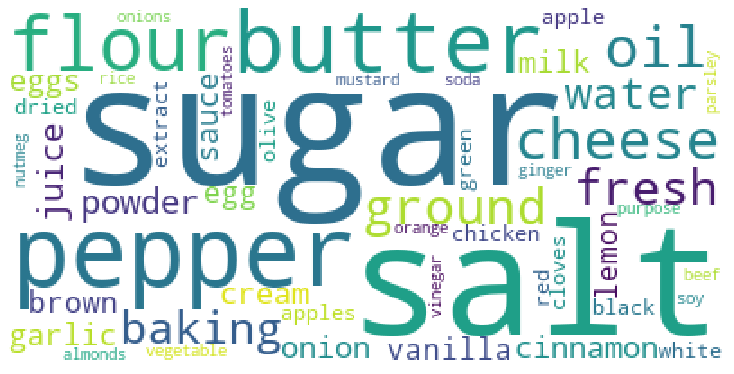

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# https://stackoverflow.com/questions/61916096/word-cloud-built-out-of-tf-idf-vectorizer-function
## Word Cloud

vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(sample_df['ingredients'])
feature_names = vectorizer.get_feature_names()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)
#df.T.sum(axis=1)
#Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(df.T.sum(axis=1))
plt.figure(figsize = (10, 15), facecolor = None) 
plt.imshow(Cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

In [38]:
#Funtion to get top order of a given user_id
def user_order_history( user_id, N):
    user_filter = user_order_cnt[user_order_cnt['user_id'] ==user_id]
    top_n_recipe = user_filter.sort_values('rec_count',ascending = False).head(N)
    return  top_n_recipe



In [ ]:
userid = int(input("Enter an User ID >>>"))
topn=int(input("Enter Top N >>>"))
user_order_history(userid,topn)


In [ ]:
user_df['recipe_id']

## Step-3. Vector Space Modeling(VSM)
#####  In this project, the Vector space model is the basic element upon which the recommendation system is built on. A vector space model is an algebraic model to represent text documents (and general objects) as vectors of identifiers, such as index terms . A vector space model uses term occurrences as vector identifiers, so vector space model (VSM) is also known as term vector model. In this project each individual ingredient (an item in the recipe database) and queried recipe are represented in the form of vectors. Vector space model has following three steps to retrieve documents according to the query -
##### a. Document cleaning and indexing, 
##### b. Term weighting, 
##### c. Similarity measure.
###### Bellow script will perform a. Document cleaning and indexing and  b. Term weighting, 


In [15]:
tf = TfidfVectorizer(
    analyzer='word', 
    ngram_range=(1, 2), 
    min_df=0.03,
    max_features=5000,
  #token_pattern=r'\b[^\d\W]+\b',
    stop_words='english',
    sublinear_tf=True
)

#recipe_ids=sample_df['id'].tolist()

tfidf_matrix = tf.fit_transform(sample_df['ingredients'])

In [16]:
tfidf_feature_names=tf.get_feature_names()
len(tfidf_feature_names)

146

##### Ingredient's TF-IDF matrix 

In [17]:
tf_df=pd.DataFrame(tfidf_matrix.todense(), columns=tf.get_feature_names(),   index=sample_df.id).sample(50, axis=1).sample(100, axis=0)
tf_df

,vanilla extract,bell,parmesan cheese,baking powder,oregano,flour,black pepper,powder salt,granulated sugar,powdered,...,red,tomato,butter,nutmeg,purpose,granulated,apple,raisins,rice,vinegar
id,,,,,,,,,,,,,,,,,,,,,
448417,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
387440,0.0,0.000000,0.0,0.241258,0.000000,0.163477,0.000000,0.298134,0.0,0.0,...,0.0,0.00000,0.154523,0.266827,0.0,0.0,0.0,0.0,0.0,0.0
279229,0.0,0.000000,0.0,0.375184,0.000000,0.254225,0.000000,0.463632,0.0,0.0,...,0.0,0.00000,0.240302,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
271012,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.225010,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
495344,0.0,0.285095,0.0,0.000000,0.284258,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.27882,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521731,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
292802,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.199547,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
192620,0.0,0.000000,0.0,0.219618,0.000000,0.251963,0.000000,0.000000,0.0,0.0,...,0.0,0.00000,0.000000,0.242894,0.0,0.0,0.0,0.0,0.0,0.0


## Step-4  Similarity algorithm implementation
##### The last step of Vector Space Model is ‘Similarity Measure’. In this last step of the Vector Space model, the documents are ranked with respect to the queried document. This step returns similarity scores computed for the degree of similarity between query and the documents. In the final result, documents are ordered according to the most relevant scores with the query. Here three most widely used similarity algorithms are used as below -
### 1. Cosine Similarity
### 2. Euclidian Distance
### 3. Pearson Co-efficient

In [19]:
#Cosine Similarity
cosine_similarities = linear_kernel(tfidf_matrix,tfidf_matrix) 

# Euclidian Distance
euc_distances = euclidean_distances(tfidf_matrix)

#Pearson_corr_array
tfidf_matrix_array = tfidf_matrix.toarray()

In [20]:
#Cosine Similarity Pairwise output
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix) 
print('pairwise dense output:\n {}\n'.format(cosine_similarities))

pairwise dense output:
 [[1.         0.05861584 0.02315997 ... 0.09825275 0.25420674 0.        ]
 [0.05861584 1.         0.09273989 ... 0.11951643 0.22585737 0.        ]
 [0.02315997 0.09273989 1.         ... 0.08854566 0.01488069 0.04290789]
 ...
 [0.09825275 0.11951643 0.08854566 ... 1.         0.28474108 0.17448674]
 [0.25420674 0.22585737 0.01488069 ... 0.28474108 1.         0.19068433]
 [0.         0.         0.04290789 ... 0.17448674 0.19068433 1.        ]]



In [ ]:
#Cosine Similarity sparse matrices output
similarities_sparse = cosine_similarity(tfidf_matrix,dense_output=False)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

In [13]:
#Euclidean Distance sparse output
similarities_sparse = euclidean_distances(tfidf_matrix)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

pairwise sparse output:
 [[0.         0.42134286 0.42134286 ... 1.39319997 1.32679126 1.38476007]
 [0.42134286 0.         0.         ... 1.39113604 1.34202882 1.3818574 ]
 [0.42134286 0.         0.         ... 1.39113604 1.34202882 1.3818574 ]
 ...
 [1.39319997 1.39113604 1.39113604 ... 0.         1.36181352 1.23230826]
 [1.32679126 1.34202882 1.34202882 ... 1.36181352 0.         1.37668274]
 [1.38476007 1.3818574  1.3818574  ... 1.23230826 1.37668274 0.        ]]



In [18]:
#also can output sparse matrices
similarities_sparse = pearsonr(tfidf_matrix,tfidf_matrix)
print('pairwise sparse output:\n {}\n'.format(similarities_sparse))

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]

In [84]:
cosine_similarities

array([[1.        , 0.9112161 , 0.9112161 , ..., 0.0294747 , 0.11977904,
        0.04121259],
       [0.9112161 , 1.        , 1.        , ..., 0.03234655, 0.09945331,
        0.04522812],
       [0.9112161 , 1.        , 1.        , ..., 0.03234655, 0.09945331,
        0.04522812],
       ...,
       [0.0294747 , 0.03234655, 0.03234655, ..., 1.        , 0.07270888,
        0.24070447],
       [0.11977904, 0.09945331, 0.09945331, ..., 0.07270888, 1.        ,
        0.05238608],
       [0.04121259, 0.04522812, 0.04522812, ..., 0.24070447, 0.05238608,
        1.        ]])

In [58]:
print('Pearson Coefficient output:\n {}\n',tfidf_matrix_array)

Pearson Coefficient output:
 {}
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.23773174]
 [0.         0.         0.         ... 0.         0.         0.        ]]


## Step-5: Recommendation Functions.
##### 1. Recommendation based on Cosine Similarity
##### 2. Recommendation based on Euclidean Distance
##### 3. Recommendation based on Pearson Correlation

In [90]:
# 1. Recommendation Function using Cosine Similarity 

indices= pd.Series(sample_df.index, index=sample_df['id'])
def get_recommendations_cosine(id, num, cosine_similarities=cosine_similarities):
    idx = indices[id]
    sim_scores =list(enumerate(cosine_similarities[idx]))   
    sim_scores = sorted(sim_scores, key= lambda x:x[1], reverse=True)
    sim_scores = sim_scores[0:num+1]
    recipe_indices = [i[0] for i in sim_scores]
    df_score= sim_scores
    #df = pd.DataFrame(sample_df[['id','name','ingredients']].iloc[recipe_indices],columns =['id','name','ingredients'])
    df = pd.DataFrame(sample_df[['name']].iloc[recipe_indices],columns =['name']),sim_scores
    return df


In [ ]:
# 2. Recommendation Function using Euclidean Distance

inddict = indices.to_dict()
D = euclidean_distances(tfidf_matrix)

def get_recommendations_euclidean(id,num):
    ind = inddict[id]
    distance = list(enumerate(D[ind]))
    distance = sorted(distance, key=lambda x: x[1])
    distance = distance[1:num+1]
    #Get the books index
    recipe_index = [i[0] for i in distance]

    #df_euclidean = pd.DataFrame(sample_df[['id','name','ingredients']].iloc[recipe_index],columns =['id','name','ingredients'])
    df_euclidean = pd.DataFrame(sample_df[['name']].iloc[recipe_index],columns =['name']),distance
    return df_euclidean

In [ ]:
# 3. Recommendation Function using Pearson Correlation

def get_recommendations_pearson(id, num):
    ind = indices[id]
    correlation = []
    for i in range(len(tfidf_matrix_array)):
        correlation.append(pearsonr(tfidf_matrix_array[ind], tfidf_matrix_array[i])[0])
    correlation = list(enumerate(correlation))
    sorted_corr = sorted(correlation, reverse=True, key=lambda x: x[1])[1:num+1]
    recipe_index = [i[0] for i in sorted_corr]
    return sample_df.iloc[recipe_index],sorted_corr

In [91]:
get_recommendations_cosine(535431,5)

(                                                  name
 10003  ham  solo savory cake                          
 7853   5 cheese baked macaroni and cheese             
 4468   alfredo s of rome s original fettuccine alfredo
 8181   apple and cheese scones                        
 4985   5 ingredient macaroni and cheese               
 4476   andrej s king crepe                            ,
 [(10003, 0.9999999999999999),
  (7853, 0.7352785207688677),
  (4468, 0.6118456849724369),
  (8181, 0.6085551340327451),
  (4985, 0.5933980172589046),
  (4476, 0.5902062203381542)])

In [99]:
recommend_euclidean_distance(535431,5)

(                                                 name
 7853  5 cheese baked macaroni and cheese             
 4468  alfredo s of rome s original fettuccine alfredo
 8181  apple and cheese scones                        
 4985  5 ingredient macaroni and cheese               
 4476  andrej s king crepe                            ,
 [(7853, 0.7276283106519869),
  (4468, 0.8810837815186059),
  (8181, 0.884810562739002),
  (4985, 0.9017782241117771),
  (4476, 0.9053107529040466)])